In [74]:
import numpy as np
import pandas as pd
import re
import datetime
import math
from matplotlib import pyplot as plt
from functools import partial
from scipy.optimize import least_squares
from scipy.integrate import odeint

In [75]:
df = pd.read_csv('project10_data.csv')

# Initialize the max

# First to clean the table with only the time series data
col_list = []
for col in df.columns:
    if re.search("^[0-9]+", col):
        col_list.append(col)

# df_clean symbolizing all dates with given data
df_clean = df[col_list]
df_clean.columns = pd.to_datetime(df_clean.columns, format="%m/%d/%y")
df_clean
# df_clean

# find t0 as the starting time for the simulation
for i in range(len(df_clean.columns)):
    if df_clean.iloc[0, i] >= 5:
        t0 = i
        break
    
print(t0)
print(df_clean.columns[i].date())

45
2020-03-07


# Exercise 2
## Question (1)
Create the rates of active infection $I(t)$ using a difference formula: $I(t) = v(t + t_0 + τ) −v(t + t_0 − τ)$, for $0 ≤ t ≤ T_{max}$. The parameter τ is related to incubation and infection period. Set $τ = 7$ days for now (the assumption is that the infection lasts up to 14 days). Plot $I = I(t)$, the rates of active infection.

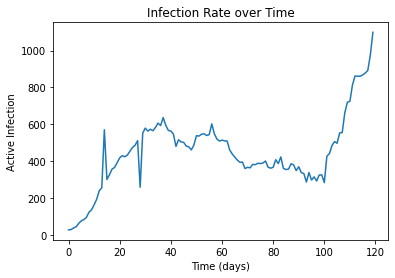

In [76]:
# Get population
population = df["Population"][0]
accumulated_cases = np.array(df_clean.iloc[0])

T_max = 119
I = np.zeros(T_max + 1)

for t in range(0, T_max + 1):
    I[t] = accumulated_cases[t + t0 + 7] - accumulated_cases[t + t0 -7]


plt.figure()
plt.plot(I)
plt.xlabel("Time (days)")
plt.ylabel("Active Infection")
plt.title("Infection Rate over Time")
plt.show()

## Question (2)
Implement an Euler scheme for solving the SIR Model with step size h = 0.01. Denote by $(S_{sim}(t),I_{sim}(t),R_{sim}(t))$ the numerical solution. Use initialization S(0) = N, I(0) from the data set, $R(0) = 0$. For this problem, the unknown parameters are $α,β,N$.

In [77]:
def f(y, t, alpha, beta):
    S, I, R = y
    d0 = -alpha * S * I  # derivative of S(t)
    d1 = alpha * S * I - beta * I  # derivative of I(t)
    d2 = beta * I  # derivative of R(t)
    return [d0, d1, d2]


def SIR_simulation(x, return_all=False):
    alpha, beta, N = x
    y_0 = [1, I[0] / N, 0]  # Susceptible, Infected, Recovered

    t = np.arange(start=1, stop=T_max+1.01, step=0.01)
    y = odeint(partial(f, alpha=alpha, beta=beta), y_0, t)
    y = y[::100]

    if return_all:
        return y[:, 0], y[:, 1], y[:, 2]

    return I - y[:, 1] * N

## Question (3)
For each combination $(α,β,N)$ in the set Ω described below repeat: 

So let's calculate all possible Ω first.

### Subquestion (a)
Run your numerical solver and produce $I_{sim}= (I_{sim}(t))$.

In [78]:
omegas = []

for alpha in [1 / 10, 1 / 9, 1 / 8, 1 / 7, 1 / 6, 1 / 5]:
    for R0 in [0.8, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2, 1.3, 1.4, 1.5, 1.6]:
        for N in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            N_max = population * N
            omegas.append((alpha, R0 * alpha, N_max))

### Subquestion (b)
Compute the $l^2$-norm squared of the residuals and save it in an array indexed by the three parameters:

Since there both alpha and beta are float numbers, we can't use them as index of the array. Indeed, we create a seprate array for storing norms, and we can concat alpha, beta, N, and norm together to from a $(720, 4)$ array.

In [79]:
# print("Question 3: omega simulation begins")
Js = []
for alpha, beta, N_max in omegas:
    S, I_hat, R = SIR_simulation((alpha, beta, N_max), return_all=True)
    J = np.sqrt(np.sum((I - I_hat * N_max) ** 2))
    Js.append(J)

# print(Js)
omegas = np.array(omegas)
Js = np.array(Js)
# print("Question 3: omega simulation ends")

## Question (4)
Visualize the function J by plotting two-dimensional surfaces $(β,N) → J(α,β,N)$ for each value of $α$. In particular determine where the minimum of this function occurs (over the finite set of values considered above).

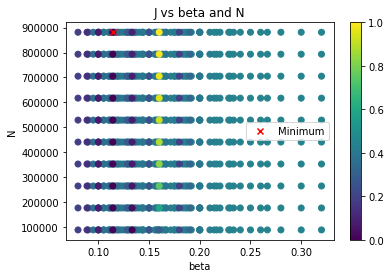

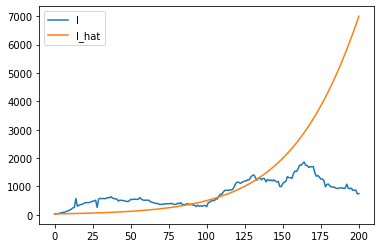

In [80]:
plt.figure()
plt.scatter(omegas[:, 1], omegas[:, 2], c=Js)

# Also plot the minimum
min_J = np.argmin(Js)
plt.scatter(omegas[min_J, 1], omegas[min_J, 2], c="red", marker="x", label="Minimum")

plt.xlabel("beta")
plt.ylabel("N")
plt.title("J vs beta and N")
plt.colorbar()
plt.legend()
# plt.savefig("J_vs_beta_and_N.png")


# Visualize the best fit
alpha, beta, N_max = omegas[min_J]
# print(data.shape)
T_max = 200
I = np.zeros(T_max + 1)

for t in range(0, T_max + 1):
    I[t] = accumulated_cases[t + t0 + 7] - accumulated_cases[t + t0 - 7]

S, I_hat, R = SIR_simulation((alpha, beta, N_max), return_all=True)
plt.figure()
plt.plot(I, label="I")
# print(S * N_max, I_hat * N_max)
# plt.plot(S * N_max, label="S")
plt.plot(I_hat * N_max, label="I_hat")
# plt.plot(R * N_max, label="R")

plt.legend()
# plt.savefig("I_vs_I_hat.png")
